In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# For optimization using pygmo
import pygmo as pg
import numpy as np
from udp_initial_condition import udp_initial_condition

# For Plotting
import matplotlib.pyplot as plt

# For cProfile evaluation
import cProfile
import pstats

In [106]:
def setup_parameters():
    """Set up of required hyperparameters for the optimization scheme. 

    Returns:
        body_density (_float_): Body density of celestial body.
        target_altitude (_float_): Squared value of the satellite's orbital target altitude.
        final_time (_float_): Final time for the integration of trajectory.
        start_time (_float_): Start time for the integration of trajectory.
        time_step (_float_): Size of initial time step for integration of trajectory.
        lower_bounds (_np.ndarray_): Lower boundary values for the initial state vector.
        upper_bounds (_np.ndarray_): Lower boundary values for the initial state vector.
        algorithm (_int_): Choice of algorithm (see file Integrator for references).
        population_size (_int_): Number of chromosomes to compare at each generation.
        number_of_generations (_int_): Number of generations for the genetic opimization.
    """
    # Setup hyperparameters:
    body_density = 533                  # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    target_altitude = 5000**2           # Target altitude squared
    final_time = 20*3600.0              # Final time
    start_time = 0                      # Starting time
    time_step = 600                     # Time step size for trajectory propagation.

    # Bounds for initial variable domain: [r_x,r_y,r_z,v_x,v_y,v_z]
    lower_bounds, upper_bounds = np.array([-6000,-6000,-6000,0,0,0]),np.array([6000,6000,6000,2.5,2.5,2.5])

    # Choose numerical integrator:
    algorithm = 3

    # Optimization parameters
    population_size = 10 #10
    number_of_generations = 32 #32

    return body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, population_size, number_of_generations

Physical dimension along x (UN-normalized):  5002.5703125 Km

   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10     4.8015e+08       0.971652        0.24702        12698.2    3.52256e+09
      2             20     4.8015e+08       0.971652        0.24702        12698.2    3.52256e+09
      3             30    3.54462e+08       0.971652        0.24702        7113.04    3.12081e+09
      4             40    4.34691e+07       0.971652        0.24702        8186.54     3.4318e+09
      5             50    4.34691e+07       0.971652        0.24702        8186.54     3.4318e+09
      6             60    1.68759e+07       0.359664        0.24702        8186.57    3.45839e+09
      7             70    1.68759e+07       0.359664        0.24702        8186.71    3.40789e+09
      8             80    1.67397e+07       0.359664        0.24702        8186.69    3.40802e+09
      9             90    1.46932e+07       0.416205    

BokehModel(combine_events=True, render_bundle={'docs_json': {'1fa74b6a-741b-457f-aeb4-217e24d58e44': {'defs': …

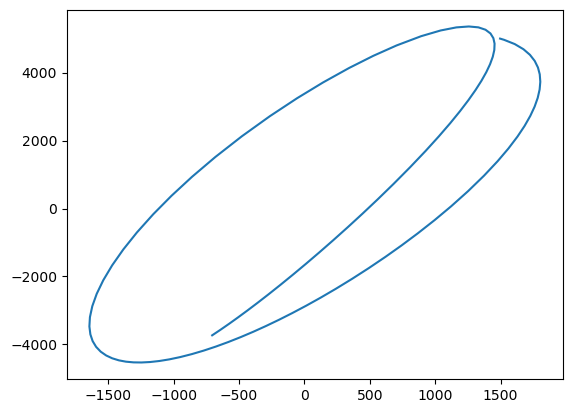

In [107]:
# Main script:

def run():
    """
    Main function for optimizing the initial state for deterministic trajectories around a 
    small celstial body using a mesh.
    """

    body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm, population_size, number_of_generations = setup_parameters()

    # Setup problem class
    udp = udp_initial_condition(body_density, target_altitude, final_time, start_time, time_step, lower_bounds, upper_bounds, algorithm)

    # Setup user defined problem (udp)
    prob = pg.problem(udp)

    # Setup optimization algorithm
    algo = pg.algorithm(pg.sade(gen = number_of_generations))
    pop = pg.population(prob = prob, size = population_size)
    
    # Run optimization
    algo.set_verbosity(1)
    pop = algo.evolve(pop)

    # Logs for output
    print("Champion fitness value: ", pop.champion_f) 
    print("Champion chromosome: ", pop.champion_x) 

    # Retrieving champion chromosome
    x = pop.champion_x

    # Compute optimized trajectory
    _, trajectory_info  = udp.compute_trajectory(x)

    # Plot optimized trajectory
    udp.plot_trajectory(trajectory_info[0:3,:])

    plt.plot(trajectory_info[0,:],trajectory_info[1,:])

def main():
    run()

if __name__ == "__main__":
    cProfile.run("main()", "output.dat")

    with open("output_time.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("time").print_stats()
    
    with open("output_calls.txt", "w") as f:
        p = pstats.Stats("output.dat", stream=f)
        p.sort_stats("calls").print_stats()
